In [1]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import RMSprop

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

print(conv_base.summary())

2022-03-08 23:07:58.275437: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-08 23:07:58.275749: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
__________________________________________________

In [3]:
folder_dir = os.getcwd()
base_dir = folder_dir + '/datasets/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20


def extract_features(directory, sample_count):
    # TODO: why shape=(sample_count, 4, 4, 512)
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=sample_count)
    # TODO: class_mode='binary' or 'multiple'? 기존에 학습되어 있는 건 못 쓰나?
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode='binary')
    i = 0
    # TODO: return of generator?
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels


train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Found 2000 images belonging to 2 classes.


2022-03-08 23:07:58.693743: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-08 23:07:58.695925: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-08 23:07:58.745938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=(4 * 4 * 512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30, 
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
  1/100 [..............................] - ETA: 26s - loss: 0.9834 - acc: 0.4000

2022-03-08 23:08:45.026262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 1s 10ms/step - loss: 0.5522 - acc: 0.7165 - val_loss: 0.4254 - val_acc: 0.8400
Epoch 2/30
  1/100 [..............................] - ETA: 0s - loss: 0.3599 - acc: 0.9500

2022-03-08 23:08:46.058676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 1s 10ms/step - loss: 0.3885 - acc: 0.8410 - val_loss: 0.3501 - val_acc: 0.8670
Epoch 3/30
100/100 [==============================] - 1s 9ms/step - loss: 0.3263 - acc: 0.8795 - val_loss: 0.3140 - val_acc: 0.8760
Epoch 4/30
100/100 [==============================] - 1s 9ms/step - loss: 0.2924 - acc: 0.8805 - val_loss: 0.2936 - val_acc: 0.8810
Epoch 5/30
100/100 [==============================] - 1s 9ms/step - loss: 0.2604 - acc: 0.8960 - val_loss: 0.2791 - val_acc: 0.8840
Epoch 6/30
100/100 [==============================] - 1s 10ms/step - loss: 0.2449 - acc: 0.9065 - val_loss: 0.2682 - val_acc: 0.8930
Epoch 7/30
100/100 [==============================] - 1s 9ms/step - loss: 0.2237 - acc: 0.9170 - val_loss: 0.2589 - val_acc: 0.8970
Epoch 8/30
100/100 [==============================] - 1s 10ms/step - loss: 0.2063 - acc: 0.9225 - val_loss: 0.2548 - val_acc: 0.8980
Epoch 9/30
100/100 [==============================] - 1s 10ms/step - loss: 0.1977 - 

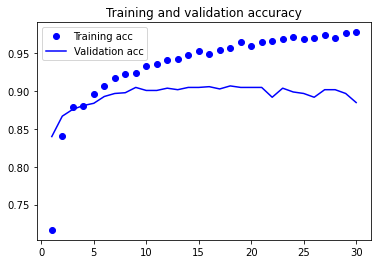

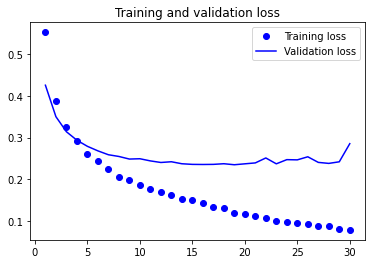

In [5]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()